# KMeans from Scratch

```yaml
Course:   DS 5001
Module:   06 Lab
Topic:    KMeans Clustering
Author:   R.C.Alvarado
Date:     21 February 2024
```

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()

In [2]:
from string import ascii_uppercase as letters
from scipy.spatial.distance import pdist

# Prepare

## Get Data IRIS

In [3]:
IRIS = sns.load_dataset('iris')
IRIS.index.name = 'obs_id'

In [4]:
IRIS.head()

,sepal_length,sepal_width,petal_length,petal_width,species
obs_id,,,,,
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


/Users/rca2t1/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


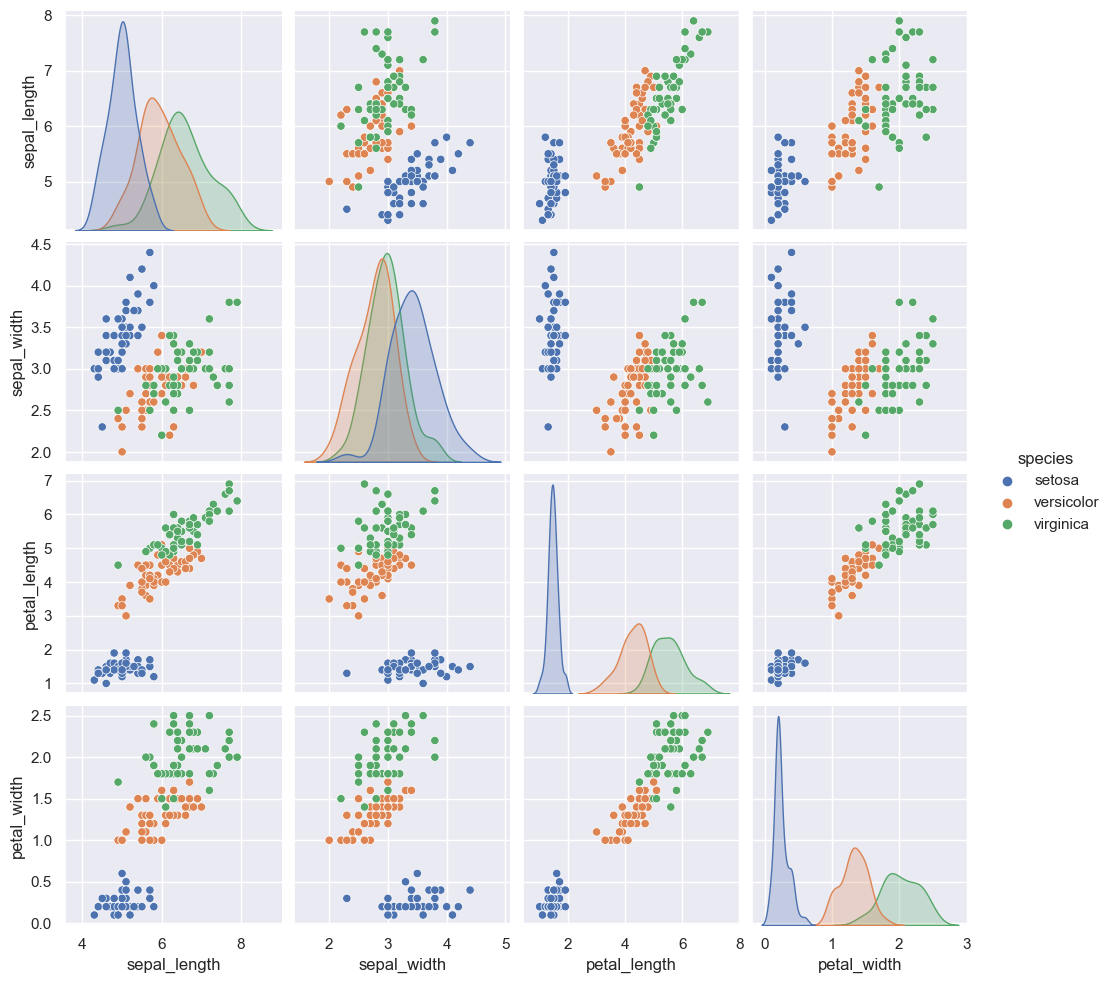

In [5]:
sns.pairplot(IRIS, hue='species');

## Extract SPECIES

In [6]:
SPECIES = IRIS.groupby('species').mean()

In [7]:
SPECIES.style.background_gradient()

,sepal_length,sepal_width,petal_length,petal_width
species,,,,
setosa,5.006000,3.428000,1.462000,0.246000
versicolor,5.936000,2.770000,4.260000,1.326000
virginica,6.588000,2.974000,5.552000,2.026000


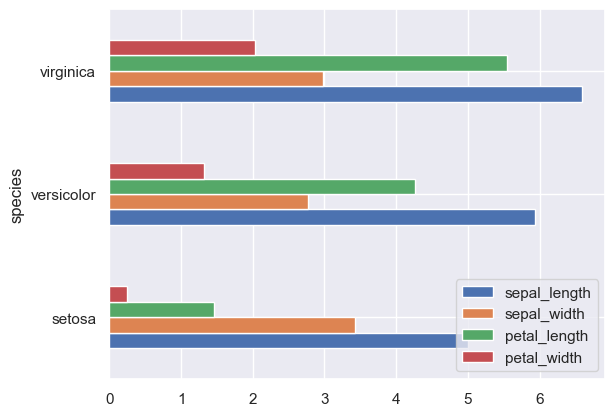

In [8]:
SPECIES.plot.barh();

In [9]:
IRIS2 = IRIS.iloc[:,:-1] # Remove the labels

# Implement

We implement K-Means clustering using Pandas.

In [34]:
def KMeans(X, k=2, d_metric='euclidean', max_iterations=100):
    
    # Randomly pick k centroids from the data
    CENTROIDS = X.sample(k)
    CENTROIDS.index.name = 'cat_id'
    CENTROIDS.index = list(letters)[:k] # Give them alphabetic names

    # Create table to store distances from centroids using a cartesian product
    combos = pd.MultiIndex.from_product([CENTROIDS.index, X.index])
    DISTANCES = pd.DataFrame({'dist': None}, index=combos)
    DISTANCES.index.names = ['cat_id', 'obs_id']

    # Iterate until convergence
    progress = [] # Save states for visualization later
    for i in range(max_iterations):

        # Get distances
        DISTANCES['dist'] = DISTANCES.apply(lambda x: 
            pdist(pd.concat([CENTROIDS.loc[x.name[0]], X.loc[x.name[1]]], axis=1).T, d_metric)[0], 
            axis=1)

        # Get min distances
        CLUSTERS = DISTANCES.unstack().idxmin().to_frame('cat')
        CLUSTERS.index = CLUSTERS.index.droplevel(0)

        # Get new centroids
        NEW_CENTROIDS = X.join(CLUSTERS).groupby('cat').mean()   

        # Test for convergence
        t = abs((CENTROIDS - NEW_CENTROIDS).sum().sum())
        progress.append(t) # Capture progress
        if t == 0:
            break            

        # Update centroids for next iteration
        CENTROIDS = NEW_CENTROIDS
            
    return X.join(CLUSTERS), progress

Use entropy to evaluate results.

In [35]:
def evaluate(result, label_df, label_name='species'):
    
    # Combine results with labels
    X = result.join(label_df[label_name])
    
    # Get results per category in a confusion matrix
    M = X.value_counts(['cat', label_name])\
        .sort_index().to_frame().unstack(fill_value=0)
    M.columns = M.columns.droplevel(0)
    
    # Get entropy per category
    MP = (M.T + .0001) / (M.T + .0001).sum()
    MI = -np.log2(MP)
    MH = (MP * MI).sum()
    MH = np.round(MH, 2).sort_values()
    
    # Get redundancy as performance measure
    MR = np.round(1 - MH.mean() / np.log2(k), 2)
    
    return M, MH, MR
    

# Test

In [36]:
k = 3
max_iterations = 10
d_metric = 'jensenshannon'
# d_metric = 'canberra'
# d_metric = 'cityblock'
# d_metric = 'euclidean'
# d_metric = 'jaccard'

In [37]:
R, progress = KMeans(IRIS2, k, d_metric, max_iterations)
M, H, G = evaluate(R, IRIS, 'species')

     sepal_length  sepal_width  petal_length  petal_width
cat                                                      
A        5.006000     3.428000      1.462000     0.246000
B        6.533962     2.916981      5.473585     1.984906
C        5.955319     2.821277      4.265957     1.327660
     sepal_length  sepal_width  petal_length  petal_width
cat                                                      
A        5.006000     3.428000      1.462000     0.246000
B        6.517647     2.935294      5.482353     2.011765
C        5.995918     2.806122      4.306122     1.326531
     sepal_length  sepal_width  petal_length  petal_width
cat                                                      
A        5.006000     3.428000      1.462000     0.246000
B        6.517647     2.935294      5.482353     2.011765
C        5.995918     2.806122      4.306122     1.326531


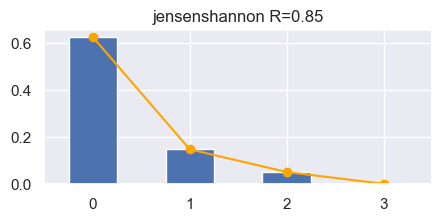

In [30]:
pd.Series(progress).plot.bar(title=f"{d_metric} R={G}", rot=0, figsize=(5,2))
pd.Series(progress).plot.line(style='o-', figsize=(5,2), color='orange');

In [31]:
M.T

cat,A,B,C
species,,,
setosa,50,0,0
versicolor,0,4,46
virginica,0,47,3


In [32]:
pd.concat([M.T.idxmax(), H], axis=1, keys=['prediction', 'entropy'])

,prediction,entropy
cat,,
A,setosa,0.00
B,virginica,0.40
C,versicolor,0.33


In [33]:
print('Grade:', G)

Grade: 0.85


# Visualize

/Users/rca2t1/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


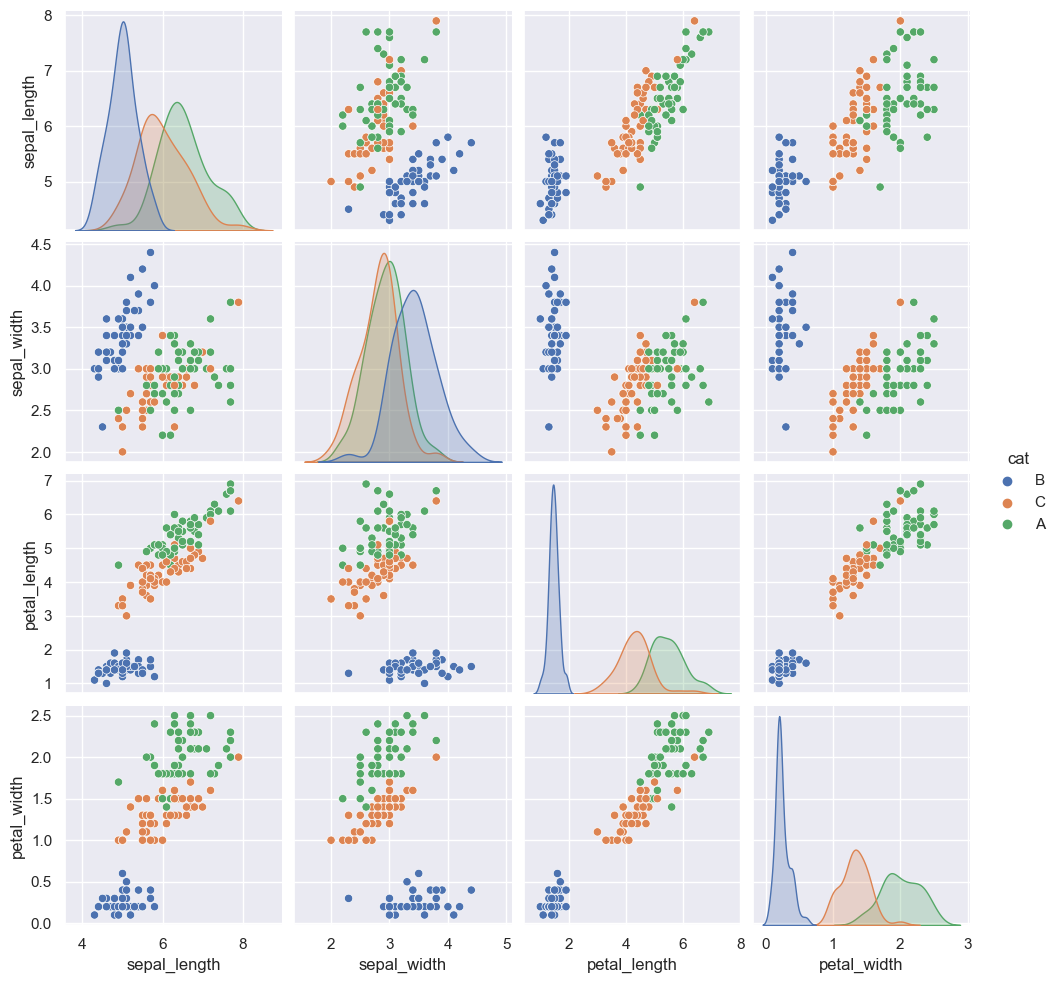

In [18]:
sns.pairplot(R, hue='cat');

# Appendix

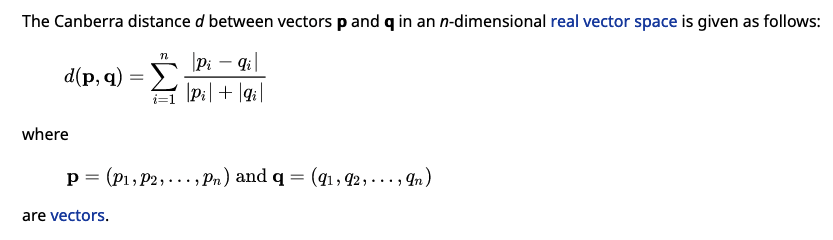
[Source](https://www.wikiwand.com/en/Canberra_distance)